## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gym==0.21.0
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 08. Rainbow

[M. Hessel et al., "Rainbow: Combining Improvements in Deep Reinforcement Learning." arXiv preprint arXiv:1710.02298, 2017.](https://arxiv.org/pdf/1710.02298.pdf)

We will integrate all the following seven components into a single integrated agent, which is called Rainbow!

1. DQN
2. Double DQN
3. Prioritized Experience Replay
4. Dueling Network
5. Noisy Network
6. Categorical DQN
7. N-step Learning

This method shows an impressive performance on the Atari 2600 benchmark, both in terms of data efficiency and final performance. 

![rainbow](https://user-images.githubusercontent.com/14961526/60591412-61748100-9dd9-11e9-84fb-076c7a61fbab.png)

However, the integration is not so simple because some of components are not independent each other, so we will look into a number of points that people especailly feel confused.

1. Noisy Network <-> Dueling Network
2. Dueling Network <-> Categorical DQN
3. Categorical DQN <-> Double DQN

In [2]:
import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

# download segment tree module
if IN_COLAB:
    !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py

# from segment_tree import MinSegmentTree, SumSegmentTree

In [3]:
import operator
from typing import Callable


class SegmentTree:
    """ Create SegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    Attributes:
        capacity (int)
        tree (list)
        operation (function)

    """

    def __init__(self, capacity: int, operation: Callable, init_value: float):
        """Initialization.

        Args:
            capacity (int)
            operation (function)
            init_value (float)

        """
        assert (
            capacity > 0 and capacity & (capacity - 1) == 0
        ), "capacity must be positive and a power of 2."
        self.capacity = capacity
        self.tree = [init_value for _ in range(2 * capacity)]
        self.operation = operation

    def _operate_helper(
        self, start: int, end: int, node: int, node_start: int, node_end: int
    ) -> float:
        """Returns result of operation in segment."""
        if start == node_start and end == node_end:
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(
                    self._operate_helper(start, mid, 2 * node, node_start, mid),
                    self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end),
                )

    def operate(self, start: int = 0, end: int = 0) -> float:
        """Returns result of applying `self.operation`."""
        if end <= 0:
            end += self.capacity
        end -= 1

        return self._operate_helper(start, end, 1, 0, self.capacity - 1)

    def __setitem__(self, idx: int, val: float):
        """Set value in tree."""
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx: int) -> float:
        """Get real value in leaf node of tree."""
        assert 0 <= idx < self.capacity

        return self.tree[self.capacity + idx]


class SumSegmentTree(SegmentTree):
    """ Create SumSegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    """

    def __init__(self, capacity: int):
        """Initialization.

        Args:
            capacity (int)

        """
        super(SumSegmentTree, self).__init__(
            capacity=capacity, operation=operator.add, init_value=0.0
        )

    def sum(self, start: int = 0, end: int = 0) -> float:
        """Returns arr[start] + ... + arr[end]."""
        return super(SumSegmentTree, self).operate(start, end)

    def retrieve(self, upperbound: float) -> int:
        """Find the highest index `i` about upper bound in the tree"""
        # TODO: Check assert case and fix bug
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)

        idx = 1

        while idx < self.capacity:  # while non-leaf
            left = 2 * idx
            right = left + 1
            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right
        return idx - self.capacity


class MinSegmentTree(SegmentTree):
    """ Create SegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    """

    def __init__(self, capacity: int):
        """Initialization.

        Args:
            capacity (int)

        """
        super(MinSegmentTree, self).__init__(
            capacity=capacity, operation=min, init_value=float("inf")
        )

    def min(self, start: int = 0, end: int = 0) -> float:
        """Returns min(arr[start], ...,  arr[end])."""
        return super(MinSegmentTree, self).operate(start, end)

## Replay buffer

Same as the basic N-step buffer. 

(Please see *01.dqn.ipynb*, *07.n_step_learning.ipynb* for detailed description about the basic (n-step) replay buffer.)

In [4]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

## Prioritized replay Buffer

`store` method returns boolean in order to inform if a N-step transition has been generated.

(Please see *02.per.ipynb* for detailed description about PER.)

In [5]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        alpha: float = 0.6,
        n_step: int = 1, 
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(
        self, 
        obs: np.ndarray, 
        act: int, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

## Noisy Layer

Please see *05.noisy_net.ipynb* for detailed description.

**References:**

- https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb
- https://github.com/Kaixhin/Rainbow/blob/master/model.py

In [6]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

## NoisyNet + DuelingNet + Categorical DQN

#### NoisyNet + DuelingNet

NoisyLinear is employed for the last two layers of advantage and value layers. The noise should be reset at evey update step.

#### DuelingNet + Categorical DQN

The dueling network architecture is adapted for use with return distributions. The network has a shared representation, which is then fed into a value stream with atom_size outputs, and into an advantage stream with atom_size × out_dim outputs. For each atom, the value and advantage streams are aggregated, as in dueling DQN, and then passed through a softmax layer to obtain the normalized parametric distributions used to estimate the returns’ distributions.

```
        advantage = self.advantage_layer(adv_hid).view(-1, self.out_dim, self.atom_size)
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
```

(Please see *04.dueling.ipynb*, *05.noisy_net.ipynb*, *06.categorical_dqn.ipynb* for detailed description of each component's network architecture.)

In [7]:
class Network(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
        )
        
        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))
        
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

## Dataset

In [8]:
df_train = pd.read_feather("../datasets/unsw-nb15/UNSW_NB15_training-set.feather")
df_test = pd.read_feather("../datasets/unsw-nb15/UNSW_NB15_testing-set.feather")
# data = pd.concat([nslkdd_test], ignore_index=True)
# print(len(data.columns))

df_train.proto = pd.Categorical(df_train.proto).codes
df_train.state = pd.Categorical(df_train.state).codes
df_train.service = pd.Categorical(df_train.service).codes


df_test.proto = pd.Categorical(df_test.proto).codes
df_test.service = pd.Categorical(df_test.service).codes
df_test.state = pd.Categorical(df_test.state).codes


# nslkdd_train = pd.get_dummies(nslkdd_train,columns=['proto' ,'service', 'state'])
# nslkdd_test = pd.get_dummies(nslkdd_test, columns=['proto' ,'service', 'state'])
df_train.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,117,0,4,2,0,496,0,90909.09375,254,...,1,2,False,0,0,1,2,False,normal,False
1,0.000008,117,0,4,2,0,1762,0,125000.00000,254,...,1,2,False,0,0,1,2,False,normal,False
2,0.000005,117,0,4,2,0,1068,0,200000.00000,254,...,1,3,False,0,0,1,3,False,normal,False
3,0.000006,117,0,4,2,0,900,0,166666.65625,254,...,1,3,False,0,0,2,3,False,normal,False
4,0.000010,117,0,4,2,0,2126,0,100000.00000,254,...,1,3,False,0,0,2,3,False,normal,False


In [9]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53946 entries, 0 to 53945
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                53946 non-null  float32 
 1   proto              53946 non-null  int16   
 2   service            53946 non-null  int8    
 3   state              53946 non-null  int8    
 4   spkts              53946 non-null  int16   
 5   dpkts              53946 non-null  int16   
 6   sbytes             53946 non-null  int32   
 7   dbytes             53946 non-null  int32   
 8   rate               53946 non-null  float32 
 9   sttl               53946 non-null  int16   
 10  dttl               53946 non-null  int16   
 11  sload              53946 non-null  float32 
 12  dload              53946 non-null  float32 
 13  sloss              53946 non-null  int16   
 14  dloss              53946 non-null  int16   
 15  sinpkt             53946 non-null  float32 
 16  dinp

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
count,53946.000000,53946.00000,53946.000000,53946.000000,53946.000000,53946.000000,5.394600e+04,5.394600e+04,53946.000000,53946.000000,...,53946.000000,53946.000000,53946.000000,53946.000000,53946.000000,53946.000000,53946.000000,53946.000000,53946.000000,53946.000000
mean,1.022179,111.51001,1.514459,3.081934,25.869759,25.967060,1.131112e+04,1.985872e+04,36179.699219,150.903681,...,5.969896,1.035628,3.273533,2.190709,1.486468,3.877711,0.009862,0.160346,3.807437,5.496330
std,3.918573,9.57705,2.442089,0.607792,161.154040,141.707459,2.072230e+05,1.865964e+05,112020.734375,106.750997,...,7.114324,1.084044,4.594301,3.990693,2.516725,6.775809,0.099564,0.561155,4.909204,7.011688
min,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,0.004238,111.00000,0.000000,3.000000,4.000000,2.000000,5.320000e+02,1.780000e+02,24.097402,31.000000,...,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,0.388905,111.00000,0.000000,3.000000,10.000000,8.000000,9.000000e+02,3.540000e+02,65.447559,254.000000,...,4.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,2.000000,3.000000
75%,0.937146,111.00000,2.000000,3.000000,16.000000,18.000000,2.158000e+03,1.824000e+03,3289.241089,254.000000,...,7.000000,1.000000,3.000000,2.000000,1.000000,4.000000,0.000000,0.000000,4.000000,6.000000
max,59.999989,130.00000,12.000000,6.000000,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1000000.000000,255.000000,...,63.000000,6.000000,59.000000,59.000000,38.000000,63.000000,2.000000,16.000000,60.000000,62.000000


In [10]:
cicdos2017_features = ["Init Bwd Win Bytes",  "Idle Min", "ACK Flag Count", "Fwd Packet Length Min", "Fwd PSH Flags"]
cicids2017_features = ["Protocol", "Avg Bwd Segment Size", "Packet Length Max", "Bwd Packet Length Min", "Fwd IAT Mean"]
cicddos2019_features = ["URG Flag Count", "Down/Up Ratio", "Bwd Packet Length Min", "ACK Flag Count", "Fwd Packets Length Total"]
nslkdd_features = ["dst_host_serror_rate", "service_private", "count","dst_host_count", "service_domain_u", "flag_REJ", "dst_host_diff_srv_rate"]
unsw_features = ["sttl", "ct_state_ttl", "service", "dload", "rate", "dmean", "dbytes", "dur", "is_sm_ips_ports", "dloss"]

important_features = unsw_features + ["attack_cat"] # Adding class for custom environment logic
important_features = list(set(important_features))
print(len(important_features))


11


In [11]:
removable_features = df_train.columns ^ important_features
print(removable_features.shape)
skinny_df_train = df_train.drop(labels=removable_features, axis='columns')
skinny_df_test = df_train.drop(labels=removable_features, axis='columns')

(33,)


C:\Users\rebus\AppData\Local\Temp\ipykernel_31216\2619472776.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  removable_features = df_train.columns ^ important_features


In [12]:
skinny_df_train.info()
skinny_df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53946 entries, 0 to 53945
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   dur              53946 non-null  float32 
 1   service          53946 non-null  int8    
 2   dbytes           53946 non-null  int32   
 3   rate             53946 non-null  float32 
 4   sttl             53946 non-null  int16   
 5   dload            53946 non-null  float32 
 6   dloss            53946 non-null  int16   
 7   dmean            53946 non-null  int16   
 8   ct_state_ttl     53946 non-null  int8    
 9   is_sm_ips_ports  53946 non-null  bool    
 10  attack_cat       53946 non-null  category
dtypes: bool(1), category(1), float32(3), int16(3), int32(1), int8(2)
memory usage: 1.3 MB


,dur,service,dbytes,rate,sttl,dload,dloss,dmean,ct_state_ttl
count,53946.000000,53946.000000,5.394600e+04,53946.000000,53946.000000,5.394600e+04,53946.000000,53946.000000,53946.000000
mean,1.022179,1.514459,1.985872e+04,36179.699219,150.903681,9.582204e+05,9.388463,170.481815,1.035628
std,3.918573,2.442089,1.865964e+05,112020.734375,106.750997,2.900338e+06,68.539247,281.487907,1.084044
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.004238,0.000000,1.780000e+02,24.097402,31.000000,1.787040e+03,0.000000,44.000000,0.000000
50%,0.388905,0.000000,3.540000e+02,65.447559,254.000000,5.700335e+03,1.000000,56.000000,1.000000
75%,0.937146,2.000000,1.824000e+03,3289.241089,254.000000,2.485340e+05,4.000000,121.000000,1.000000
max,59.999989,12.000000,1.465753e+07,1000000.000000,255.000000,2.082111e+07,5507.000000,1500.000000,6.000000


In [13]:
def balancing_dataset_sampler_df(df, train_frac=0.2, val_frac=0.1, test_frac=0.7):
    col = df.columns[-1]
    print(col)
    cols = df.columns[:-1]
    print(cols)
    vc = df[col].value_counts()
    print(vc)
    n = vc.iloc[-1]
    print(n)
    m = vc.iloc[0]
    print(m)
    print(int(m-n))
    initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
    print(initial_cut.index)
    df = df.drop(index=initial_cut.index)
    vc = df[col].value_counts()
    print(vc)
    print(int(n*train_frac))
    train_df = df.groupby(col).apply(lambda x: x.sample(n=int(n*train_frac), replace=False))
    train_df.reset_index(level=0, inplace=True, drop=True)
    df = df.drop(index=train_df.index)

    validation_df = df.groupby(col).apply(lambda x: x.sample(n=int(n*val_frac), replace=False))
    validation_df.reset_index(level=0, inplace=True, drop=True)
    df = df.drop(index=validation_df.index)

    test_df = df.groupby(col).apply(lambda x: x.sample(n=int(n*test_frac), replace=False))
    test_df.reset_index(level=0, inplace=True, drop=True)
    df = df.drop(index=test_df.index)

    return train_df[cols], train_df[col], validation_df[cols], validation_df[col], test_df[cols], test_df[col]


In [14]:
def nslkdd_split_df(train_df, test_df):
    train_col = train_df.columns[-1]
    print(train_col)
    train_cols = train_df.columns[:-1]
    print(train_cols)
    test_col = test_df.columns[-1]
    print(test_col)
    test_cols = test_df.columns[:-1]
    print(test_cols)

    return train_df[train_cols], train_df[train_col], test_df[test_cols], test_df[test_col]

In [15]:
def malicious_benign(df):
    print(df['attack_cat'].value_counts())
    df['attack_cat'] = df['attack_cat'].astype('object')
    atk_idx = df.loc[df['attack_cat'] != "normal"].index
    df.loc[atk_idx, 'attack_cat'] = 1.0
    df.loc[df.index.difference(atk_idx), 'attack_cat'] = 0.0
    df['attack_cat'] = df['attack_cat'].astype(dtype=np.float32)

In [16]:
malicious_benign(skinny_df_train)
print()
malicious_benign(skinny_df_test)

normal            34200
exploits           7126
fuzzers            4394
generic            3640
reconnaissance     2469
dos                1315
shellcode           377
analysis            312
backdoor             70
worms                43
Name: attack_cat, dtype: int64

normal            34200
exploits           7126
fuzzers            4394
generic            3640
reconnaissance     2469
dos                1315
shellcode           377
analysis            312
backdoor             70
worms                43
Name: attack_cat, dtype: int64


In [17]:
extra_removables = skinny_df_test.columns ^ skinny_df_train.columns
print(extra_removables)
try:
    skinny_df_train = skinny_df_train.drop(labels=extra_removables, axis='columns')
except:
    pass
try:
    skinny_df_test.drop(labels=extra_removables, axis='columns')
except:
    pass
skinny_df_train.info()

Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53946 entries, 0 to 53945
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dur              53946 non-null  float32
 1   service          53946 non-null  int8   
 2   dbytes           53946 non-null  int32  
 3   rate             53946 non-null  float32
 4   sttl             53946 non-null  int16  
 5   dload            53946 non-null  float32
 6   dloss            53946 non-null  int16  
 7   dmean            53946 non-null  int16  
 8   ct_state_ttl     53946 non-null  int8   
 9   is_sm_ips_ports  53946 non-null  bool   
 10  attack_cat       53946 non-null  float32
dtypes: bool(1), float32(4), int16(3), int32(1), int8(2)
memory usage: 1.5 MB


C:\Users\rebus\AppData\Local\Temp\ipykernel_31216\1986725243.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  extra_removables = skinny_df_test.columns ^ skinny_df_train.columns


In [18]:
x_train, y_train, x_test, y_test  = nslkdd_split_df(skinny_df_train, skinny_df_test)

attack_cat
Index(['dur', 'service', 'dbytes', 'rate', 'sttl', 'dload', 'dloss', 'dmean',
       'ct_state_ttl', 'is_sm_ips_ports'],
      dtype='object')
attack_cat
Index(['dur', 'service', 'dbytes', 'rate', 'sttl', 'dload', 'dloss', 'dmean',
       'ct_state_ttl', 'is_sm_ips_ports'],
      dtype='object')


In [19]:
y_train = y_train.to_frame()
y_test = y_test.to_frame()

# custom keys -> replace by index

x_train = x_train.set_index([pd.Index(range (0, len(x_train)))])
y_train = y_train.set_index([pd.Index(range (0, len(y_train)))])
x_test = x_test.set_index([pd.Index(range (0, len(x_test)))])
y_test = y_test.set_index([pd.Index(range (0, len(y_test)))])


## Rainbow Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

#### Categorical DQN + Double DQN

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Here, we use `self.dqn` instead of `self.dqn_target` to obtain the target actions.

```
        # Categorical DQN + Double DQN
        # target_dqn is used when we don't employ double DQN
        next_action = self.dqn(next_state).argmax(1)
        next_dist = self.dqn_target.dist(next_state)
        next_dist = next_dist[range(self.batch_size), next_action]
```

In [20]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            
            # NoisyNet: removed decrease of epsilon
            
            # PER: increase beta
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)
                
        self.env.close()
                
    def test(self) -> None:
        """Test the agent."""
        self.is_test = True
        TP, FP, TN, FN = 0,0,0,0
        # for recording a video
        naive_env = self.env
        self.env = IdsEnv(images_per_episode=1, dataset=(x_test, y_test), random=False)

        action = self.env.reset()
        done = False
        count = 0
        try:
            while True:
                     
                done = False
                while not done:
                    count += 1
                    action = self.select_action(action)
                    next_action, rew, done, info = self.env.step(action)
                    action = next_action
                    label = info['label']
                    if label == 0 and rew > 0:
                        TP += 1
                    if label == 0 and rew == 0:
                        FP += 1
                    if label == 1 and rew > 0:
                        TN += 1
                    if label == 1 and rew == 0:
                        FN += 1
        except StopIteration:
            accuracy = (float(TP + TN) / (TP + FP + FN + TN)) 
            precision = (float(TP) / (TP + FP))
            try:
                recall = (float(TP) / (TP + FN)) # = TPR = Sensitivity
            except:
                recall = 0
            try:
                FPR = (float(FP) / (TN + FP)) # 1 - specificity
            except:
                FPR = 0
            try:
                f1_score = 2 * (precision * recall) / (precision + recall)
            except:
                f1_score = 0
            print()
            print('validation done...')
            print('Accuracy: {0}%'.format(accuracy * 100))
            print('Precision: {0}%'.format(precision * 100))
            print('Recall/TPR/Sensitivity: {0}%'.format(recall * 100))
            print('FPR: {0}%'.format(FPR * 100))
            print('F1 score: {0}'.format(f1_score))
            print('count: {0}'.format(count))
        self.env.close()
        
        # reset
        self.env = naive_env
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [21]:
class IdsEnv(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(x_train, y_train), random=True):
        # Actions we can take, classify as malicious or non-malicious (later also the correct attack)
        # change to 19 if detectiong all different attacks
        self.action_space = gym.spaces.Discrete(2)
         # All the features we have, len(important_features) - 1 features and 1 label. Label should not be included
        self.observation_space = gym.spaces.Box(low=float('-inf'), high=float('inf'), shape=(len(skinny_df_train.columns) - 1,))
        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0
    
    def step(self, action):
        done = False
        reward = int(action == self.expected_action)
        current_label = self.expected_action
        obs = self._next_obs()
        
        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {'label': current_label}

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y.iloc[next_obs_idx,:])
            obs = self.x.iloc[next_obs_idx,:]

        else:
            obs = self.x.iloc[self.dataset_idx]
            self.expected_action = int(self.y.iloc[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()
        return obs
    
    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

In [22]:
# environment
env = IdsEnv(images_per_episode=1000)

## Set random seed

In [23]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
random.seed(seed)
seed_torch(seed)
env.seed(seed)

C:\Users\rebus\anaconda3\envs\MP\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


[777]

## Initialize

In [24]:
# parameters
num_frames = int(1.0e5)
memory_size = 100000
batch_size = 128
target_update = 10000

# train
agent = DQNAgent(env, memory_size, batch_size, target_update)

cuda


## Train

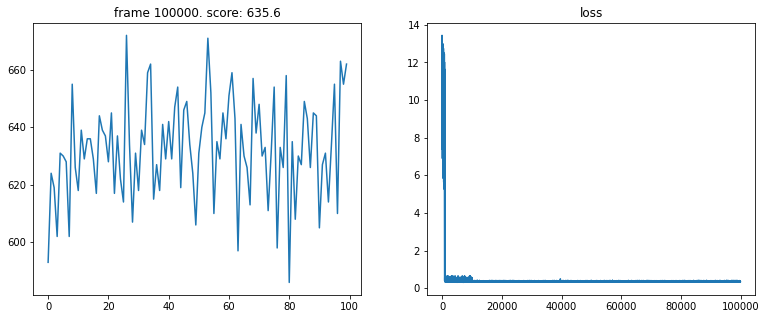

In [25]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [26]:
agent.test()


validation done...
Accuracy: 63.39537297938603%
Precision: 100.0%
Recall/TPR/Sensitivity: 63.39537297938603%
FPR: 0%
F1 score: 0.7759751310385514
count: 53945
